## WCF Modelling

This code:

- Import a CSV and create a random forest model
- Choose a location and download some satellite data
- Apply model to satellite image
- Do some plotting

#### Questions and things to do

- Why is the data in the geomedian orders larger than the data in the csv?
    - I think the geomedian is in DNs and the training data is SR?
- What is the threshold for woody / not woody?
    - If it measures how woody, everything over 0 is woody?
- Fiddle with the random forest parameters
- Should I transform the inputs to be gaussian?

#### Other things to consider

- WCF saturates above 0.6

#### Sources of error

- Since WCF is derived from single-date LiDAR data and an annual geomedian is being used to predict it the geomedian may not represent the same vegetation as was present when LiDAR was acquired.
- Mixed pixels containing water and vegetation tended to overestimate WCF.
- Vegetation lower than 2m (e.g. dense shrubland or new plantations) could have a WCF from Landsat, although LiDAR would not have.

LiDAR
- Variation in pulse density (4 to 8 ppm)
- Variation in achieved density returns (4 to 20 ppm)

WCF derived from LiDAR was suprisingly low
- possibly due to attribution of VCF to height, and only above 2m is considered in WCF
- identifying points in LiDAR waveform is more challenging over dense uniform forest

Overall systematic underestimation of true cover at high values



#### Import modules

In [1]:
%matplotlib inline

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import display_map
from dea_plotting import rgb
from dea_classificationtools import predict_xr
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics

import numpy as np
import xarray as xr


In [2]:
dc = datacube.Datacube(app='Alberts Forest')

#### Import training data csv

In [3]:
path = 'WCF_traindata_22102019.csv'
df = pd.read_csv(path)
df.head()

,WCF,blue,green,red,nir,swir1,swir2
0,0.261320,0.034313,0.047605,0.052131,0.19575,0.14400,0.082638
1,0.116210,0.044998,0.067579,0.083996,0.20979,0.25615,0.160270
2,0.408240,0.022349,0.035390,0.040748,0.19127,0.11858,0.070578
3,0.000000,0.048717,0.077072,0.091846,0.24272,0.29843,0.190590
4,0.053365,0.059975,0.087660,0.104420,0.23314,0.27891,0.184080


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3.4300e+02, 2.9910e+03, 1.0091e+04, 4.6360e+03, 3.0950e+03,
        3.3790e+03, 2.5860e+03, 2.6170e+03, 2.3170e+03, 2.2930e+03,
        1.8350e+03, 1.6390e+03, 1.5450e+03, 9.6700e+02, 3.0900e+02,
        1.2600e+02, 8.6000e+01, 7.3000e+01, 4.7000e+01, 5.5000e+01,
        4.0000e+01, 3.0000e+01, 3.1000e+01, 1.8000e+01, 1.1000e+01,
        1.9000e+01, 1.2000e+01, 4.0000e+00, 6.0000e+00, 3.0000e+00]),
 array([-0.0017486 ,  0.01440769,  0.03056397,  0.04672026,  0.06287655,
         0.07903283,  0.09518912,  0.11134541,  0.12750169,  0.14365798,
         0.15981427,  0.17597055,  0.19212684,  0.20828313,  0.22443941,
         0.2405957 ,  0.25675199,  0.27290827,  0.28906456,  0.30522085,
         0.32137713,  0.33753342,  0.35368971,  0.36984599,  0.38600228,
         0.40215857,  0.41831485,  0.43447114,  0.45062743,  0.46678371,
         0.48294   ]),
 <a list of 30 Patch objects>)

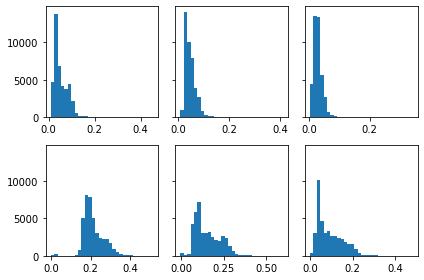

In [4]:
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
axs[0,0].hist(df[' red'],bins=30)
axs[0,1].hist(df[' green'],bins=30)
axs[0,2].hist(df['blue'],bins=30)
axs[1,0].hist(df[' nir'],bins=30)
axs[1,1].hist(df[' swir1'],bins=30)
axs[1,2].hist(df[' swir2'],bins=30)

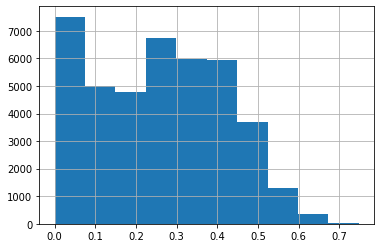

In [5]:
# Plot a histogram of WCF values
df['WCF'].hist()

#### Create and evaluate model

https://www.youtube.com/watch?v=YYjvkSJoui4 

In [6]:
# Handle misisng data
df = df.dropna()

# Define dependent variable
Y = df['WCF']

# Define independent variables
X = df.drop(labels=['WCF'],axis=1)

# Split model into testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

# Define model
model = RandomForestRegressor(n_estimators=100, # number of trees in forest, is this equal to ensemble?
                              #criterion = 'mse', # function to measure the quality of the split
                              #max_depth = None, # max depth of tree. If None, then nodes are expanded until all laves are pure, or until all leaves contain less than min_samples_split
                              min_samples_split = 30, # Min no. samples required to be at a leaf node 
                              #min_weight_fraction_leaf = 0, # The min weighted fraction. Samples have equal weight when 0.
                              #max_features = 'auto', # The number of features to consider when looking for the best split
                              #max_leaf_nodes = None, # If None, then unlimited number of leaf nodes
                              #min_impurity_decrease = 0, # Split nodes to decrease impurity
                              #min_impurity_split = 1e-7, # Replaced by min_impurity_decrease
                              #bootstrap = true, # Whether to bootstrap samples when building trees. If False, the whole dataset is used ot build each tree.
                              #oob_score = False, # Whether to use out-of-bag samples to estimate R^2 on unseen data
                              #n_jobs = None, # The number of jobs to run in parallel. None means 1
                              random_state=30, # Controls the randomness of bootstrapping and the sampling of features to consider for bets node split
                              #verbose = 0, # Controls the verbosity when fititng and predicting
                              #warm_start = False, # False - fit new forest, True - reuse solution from previous call amd add more estimators to ensemble
                              #ccp_alpha = 0.0, # Complexity parameter
                              #max_samples = None, # If bootstrap is True, the numbe rof samples to draw from X to train each base estimator
                             )

# Fit model
model.fit(X_train,Y_train)

# Predict test data
prediction_test = model.predict(X_test)

In [7]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 30,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

In [8]:
# Set up parameters
parameters = [{'n_estimators':[10,50,100,150,200],'min_samples_split':[10,30,60,90],'random_state':[10,30,60,90],'criterion':['gini']},
             {'n_estimators':[10,50,100,150,200],'min_samples_split':[10,30,60,90],'random_state':[10,30,60,90],'criterion':['entropy']},
             ]


# Do the grid search
grid_search = GridSearchCV(model,parameters)

In [9]:
grid_search#.best_params_

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=30,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False,...
             iid='deprecated', n_jobs=None,
             param_grid=[{'criterion': ['gini'],
                          'mi

#### Performance metrics

In draft:
- Root mean square estimate (RMSE) = 0.061
- Coefficient of determination (R^2) = 0.862
- Nash-Sutcliffe model efficiency (ME) = 0.862

In [10]:
# Metrics
print('Explained variance score = ')
print(metrics.explained_variance_score(Y_test, prediction_test)) # what measure to use https://scikit-learn.org/stable/modules/model_evaluation.html
print('R^2 =')
print(metrics.r2_score(Y_test, prediction_test))
print('RMSE =')
print(metrics.mean_squared_error(Y_test, prediction_test))

Explained variance score = 
0.870106227647442
R^2 =
0.8700947754187366
RMSE =
0.0034384990607893204


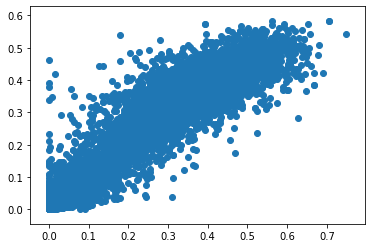

In [11]:
plt.scatter(Y_test, prediction_test)

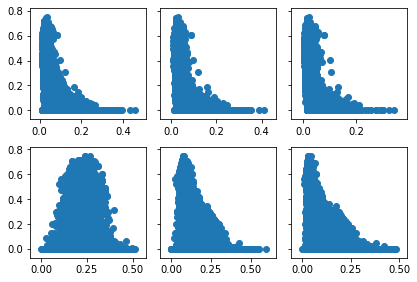

In [12]:
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
axs[0,0].scatter(df[' red'],df['WCF'])
axs[0,1].scatter(df[' green'],df['WCF'])
axs[0,2].scatter(df['blue'],df['WCF'])
axs[1,0].scatter(df[' nir'],df['WCF'])
axs[1,1].scatter(df[' swir1'],df['WCF'])
axs[1,2].scatter(df[' swir2'],df['WCF'])

#### Order of importance



nir, blue, swir1, green, swir2, red

In [13]:
# Determine the importance of each of the bands
#print(model.feature_importances_) # need to format nicely
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)

 red      0.592814
 nir      0.110904
 swir1    0.090928
 swir2    0.084813
 green    0.081431
blue      0.039109
dtype: float64


#### Choose location

When models were made for individual locations the performance varied significantly.

- Whroo in Victoria have an R^2 of only 0.35 (-36.703137, 145.035462)
- ACT had an R^2 of 0.87 (-35.434967, 149.002428)

In [14]:
# Set the central latitude and longitude
central_lat = -35.434967
central_lon = 149.002428

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [15]:
start_date = '2009'
end_date = '2009' 

#Load all data in baseline period available from Near Real Time data

baseline_da = dc.load(
              product='ls5_nbart_geomedian_annual',# ls5_nbart_geomedian_annual, ls8_nbart_geomedian_annual
              x=study_area_lon,
              y=study_area_lat,
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              resolution=(-10, 10),
              #group_by='solar_day'
)
baseline_da

<xarray.Dataset>
Dimensions:  (time: 1, x: 2093, y: 2444)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01
  * y        (y) float64 -3.961e+06 -3.961e+06 ... -3.985e+06 -3.985e+06
  * x        (x) float64 1.526e+06 1.526e+06 1.526e+06 ... 1.547e+06 1.547e+06
Data variables:
    blue     (time, y, x) int16 483 483 475 475 475 469 ... 626 626 563 563 509
    green    (time, y, x) int16 878 878 848 848 848 806 ... 975 975 847 847 775
    red      (time, y, x) int16 1032 1032 995 995 995 ... 1132 1012 1012 933
    nir      (time, y, x) int16 2270 2270 2253 2253 2253 ... 2186 2107 2107 1978
    swir1    (time, y, x) int16 2815 2815 2738 2738 2738 ... 3522 3280 3280 3133
    swir2    (time, y, x) int16 1816 1816 1791 1791 1791 ... 2288 2077 2077 1911
Attributes:
    crs:      EPSG:3577

In [16]:
print(baseline_da.min())
print(baseline_da.max())
print(df.min())
print(df.max())

<xarray.Dataset>
Dimensions:  ()
Data variables:
    blue     int16 64
    green    int16 199
    red      int16 167
    nir      int16 306
    swir1    int16 109
    swir2    int16 63
<xarray.Dataset>
Dimensions:  ()
Data variables:
    blue     int16 3139
    green    int16 4033
    red      int16 4263
    nir      int16 5333
    swir1    int16 5907
    swir2    int16 5752
WCF       0.000000
blue      0.002593
 green    0.007810
 red      0.009438
 nir     -0.000367
 swir1   -0.004460
 swir2   -0.001749
dtype: float64
WCF       0.74829
blue      0.34068
 green    0.41201
 red      0.45516
 nir      0.51468
 swir1    0.59915
 swir2    0.48294
dtype: float64


#### Prepare dataset to go in model

In [17]:
flat = sklearn_flatten(baseline_da)
flat

array([[ 483,  878, 1032, 2270, 2815, 1816],
       [ 483,  878, 1032, 2270, 2815, 1816],
       [ 389,  693,  801, 2129, 2328, 1503],
       ...,
       [ 502,  768,  936, 1982, 3020, 1862],
       [ 509,  775,  933, 1978, 3133, 1911],
       [ 509,  775,  933, 1978, 3133, 1911]], dtype=int16)

In [18]:
#normal = preprocessing.normalize(flat)
#normal = (flat-flat.mean())/(flat.max()-flat.min())
normal = flat/10000
print(flat.min())
print(flat.max())
print(normal.min())
print(normal.max())
normal

63
5907
0.0063
0.5907


array([[0.0483, 0.0878, 0.1032, 0.227 , 0.2815, 0.1816],
       [0.0483, 0.0878, 0.1032, 0.227 , 0.2815, 0.1816],
       [0.0389, 0.0693, 0.0801, 0.2129, 0.2328, 0.1503],
       ...,
       [0.0502, 0.0768, 0.0936, 0.1982, 0.302 , 0.1862],
       [0.0509, 0.0775, 0.0933, 0.1978, 0.3133, 0.1911],
       [0.0509, 0.0775, 0.0933, 0.1978, 0.3133, 0.1911]])

#### Run model

In [19]:
results = model.predict(normal)
results

array([0.00360929, 0.00360929, 0.03013585, ..., 0.00839206, 0.00718376,
       0.00718376])

#### Unflatten results

In [20]:
unflat = (sklearn_unflatten(results,baseline_da).transpose())[0]
unflat

<xarray.DataArray (y: 2444, x: 2093)>
array([[0.00360929, 0.00360929, 0.00664866, ..., 0.14445623, 0.14445623,
        0.08226553],
       [0.00360929, 0.00360929, 0.00664866, ..., 0.14445623, 0.14445623,
        0.08226553],
       [0.03013585, 0.03013585, 0.02338082, ..., 0.05571921, 0.05571921,
        0.04327684],
       ...,
       [0.26239063, 0.26239063, 0.26308577, ..., 0.00858604, 0.00858604,
        0.00839206],
       [0.26593031, 0.26593031, 0.27779625, ..., 0.0099142 , 0.0099142 ,
        0.00718376],
       [0.26593031, 0.26593031, 0.27779625, ..., 0.0099142 , 0.0099142 ,
        0.00718376]])
Coordinates:
  * x        (x) float64 1.526e+06 1.526e+06 1.526e+06 ... 1.547e+06 1.547e+06
  * y        (y) float64 -3.961e+06 -3.961e+06 ... -3.985e+06 -3.985e+06
    time     datetime64[ns] 2009-01-01

In [21]:
max(results)

0.498656719964189

#### Plot some results

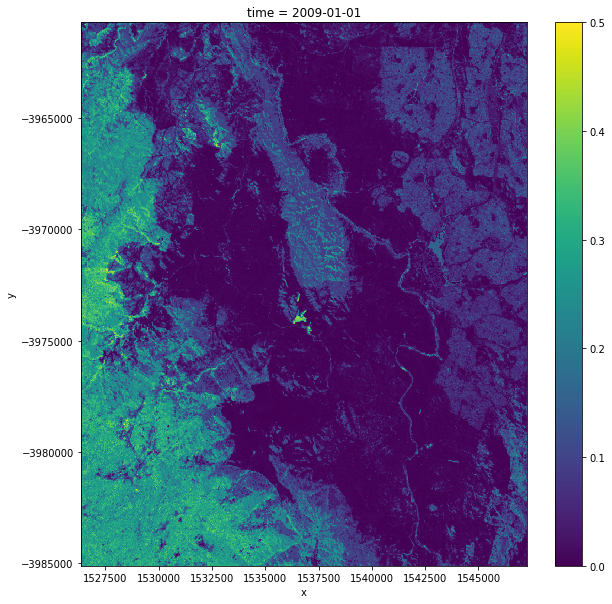

In [22]:
# Woody cover in training data varies between 0 and 0.75
unflat.plot(figsize=(10,10),vmin=0,vmax=0.5)

(array([ 17809.,  45250.,  69183., 133995., 127857., 112859., 120992.,
        125537., 120230., 110547., 103228.,  91551.,  80085.,  69825.,
         60999.,  51740.,  49427.,  43600.,  41230.,  37767.,  34172.,
         33293.,  30451.,  28726.,  25712.,  23231.,  22357.,  20619.,
         18724.,  17720.,  16901.,  15935.,  14828.,  13393.,  13861.,
         12231.,  11856.,  11611.,  11071.,  11215.,  10797.,  10536.,
         10373.,   9876.,   9764.,   9447.,  10048.,   9602.,  10567.,
         10342.,   9911.,   9627.,   9874.,  10545.,  10515.,  10805.,
         10888.,  11244.,  10773.,  11286.,  11618.,  11475.,  11026.,
         10585.,  11037.,  11112.,  11431.,  10999.,  10528.,  10793.,
         10809.,  10226.,  10032.,   9584.,   9179.,   9687.,   9448.,
          9008.,   8653.,   7909.,   7671.,   7462.,   6731.,   7265.,
          6619.,   7125.,   6840.,   6795.,   7063.,   6858.,   6910.,
          6662.,   7414.,   7434.,   7236.,   8032.,   8167.,   8247.,
      

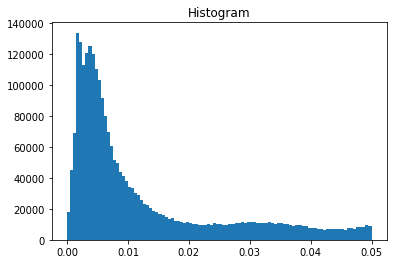

In [23]:
xr.plot.hist(unflat,bins=100,range=(0,0.05))

#### Apply a threshold

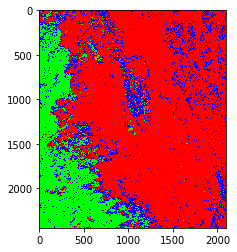

In [24]:
not_woody = unflat<=0.1
woody = np.logical_and(unflat>0.1,unflat<=0.2)
very_woody = unflat>0.2

#We use this numpy function to stack 2-dimensional arrays over the 3rd axis or depth:
classes= np.dstack((not_woody,very_woody,woody)).astype(np.uint8) * 255

plt.imshow(classes)

In [25]:
# Constants for calculating burnt area
resolution = (-30,30)
pixel_length = resolution[1] # in metres
#print(pixel_length)
m_per_km = 1000 # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length**2/m_per_km**2
#print(area_per_pixel)

# Calculate areas
not_woody_area = np.sum(not_woody.values)*area_per_pixel
woody_area = np.sum(woody.values)*area_per_pixel
very_woody_area = np.sum(very_woody.values)*area_per_pixel

print('Not woody:  ',not_woody_area)
print('Woody:      ',woody_area)
print('Very woody: ',very_woody_area)

Not woody:   3111.1911
Woody:       641.4678
Very woody:  851.1039


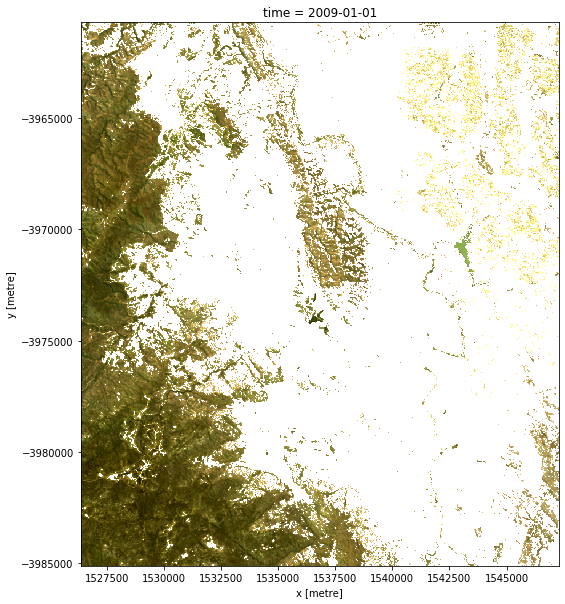

In [26]:
# Mask
masked = baseline_da.where(unflat>0.1)
rgb(masked, bands=['red', 'green', 'blue'],size=10)

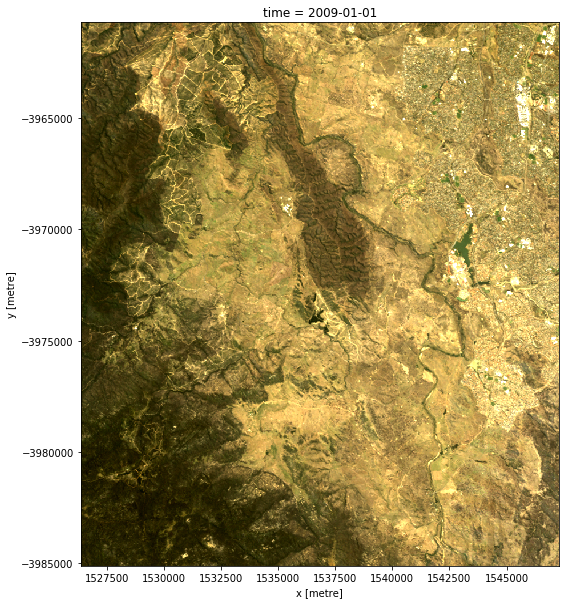

In [27]:
# Visualise median image as true colour image
rgb(baseline_da, bands=['red', 'green', 'blue'],size=10)

In [45]:
# Export to geotiff
from datacube.helpers import write_geotiff
unflat.attrs['crs']='EPSG:3577'
wcf_ds = unflat.to_dataset(name='wcf')
write_geotiff('Example_wcf.tif', wcf_ds)
